In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Käytä esikoulutettua mallia (esim. VGG16) piirteiden irrottamiseen
Kouluta vain oma luokittelija (fully connected) irrotettujen piirteiden päälle
Vertaa suorituskykyä ensimmäiseen malliin

In [58]:
conv_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False

In [61]:

def get_features_and_labels(dataset):
    all_features, all_labels = [], []
    for images, labels in dataset:
        if labels is None:
            continue
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return tf.concat(all_features, axis=0), tf.concat(all_labels, axis=0)


In [63]:
train_dataset = image_dataset_from_directory("kuvat/train", image_size=(224, 224), batch_size=32)
validation_dataset = image_dataset_from_directory("kuvat/validation", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory("kuvat/test", image_size=(224, 224), batch_size=32)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


In [64]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.2687 - loss: 32.2112 - val_accuracy: 0.4444 - val_loss: 29.1320
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8040 - loss: 4.5405 - val_accuracy: 0.5926 - val_loss: 12.8526
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8963 - loss: 3.4089 - val_accuracy: 0.6667 - val_loss: 6.3572
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.9539 - loss: 0.5569 - val_accuracy: 0.7037 - val_loss: 5.2798
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9675 - loss: 0.6156 - val_accuracy: 0.7037 - val_loss: 6.9329
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9561 - loss: 0.5417 - val_accuracy: 0.7037 - val_loss: 9.0181
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 9.5301e-06 - val_accuracy: 0.6667 - val_loss: 10.7844
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9968 - loss: 0.0374 - val_accuracy: 0.6667 - val_l

In [66]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9259 - loss: 3.6049
Test accuracy: 0.926


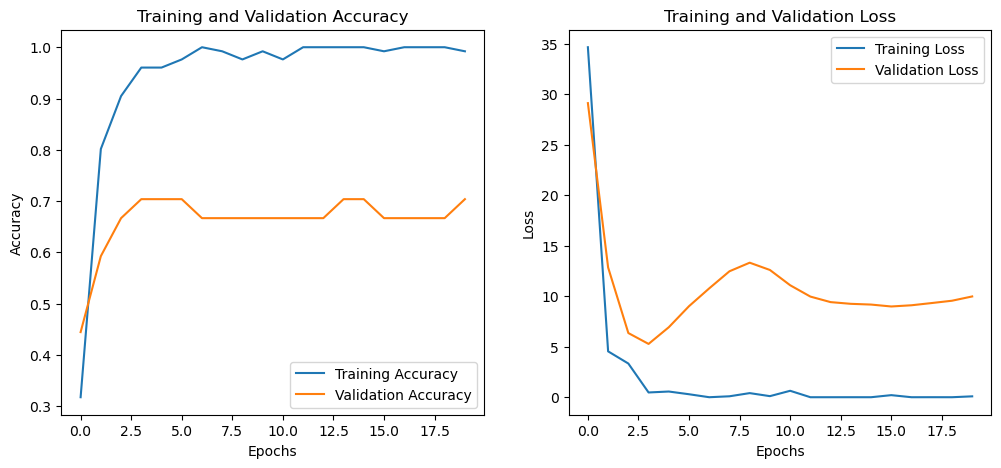

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
              precision    recall  f1-score   support

    haarukka       0.82      1.00      0.90         9
     lusikka       1.00      1.00      1.00         9
      veitsi       1.00      0.78      0.88         9

    accuracy                           0.93        27
   macro avg       0.94      0.93      0.92        27
weighted avg       0.94      0.93      0.93        27



In [67]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

y_pred = np.argmax(model.predict(test_features), axis=1)
print(classification_report(test_labels, y_pred, target_names=['haarukka', 'lusikka', 'veitsi']))
